In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from antiberty import AntiBERTyRunner
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

df: pd.DataFrame = pd.read_csv('../../data/CoV-AbDab_080224.csv')

antiberty = AntiBERTyRunner()

In [9]:
# 1. Initialize on GPU if possible, but keep cache clear
torch.cuda.empty_cache()
# If it still crashes on init, change to device="cpu"
antiberty = AntiBERTyRunner() 

def embed_pandas_column(series, batch_size=5):
    """
    Processes a pandas column of sequences in small batches to avoid OOM.
    """
    sequences = series.astype(str).tolist()
    all_embeddings = []
    
    # Use torch.no_grad() to save massive amounts of VRAM
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size)):
            batch = sequences[i : i + batch_size]
            
            # Generate embeddings for the batch
            batch_embeddings = antiberty.embed(batch)
            
            # Mean-pool each sequence in the batch [Length x 512] -> [512]
            for emb in batch_embeddings:
                all_embeddings.append(emb.mean(axis=0).cpu().numpy())
            
            # Manually clear cache every few batches to stay under 3.68GB
            if i % (batch_size * 5) == 0:
                torch.cuda.empty_cache()
                
    return np.array(all_embeddings)

# --- USAGE ---
# df['VH'] is your column of antibody sequences
X_features = embed_pandas_column(df['VHorVHH'], batch_size=5)

print(f"Feature matrix shape: {X_features.shape}") # Should be (n_samples, 512)

100%|██████████| 2584/2584 [00:40<00:00, 63.21it/s]

Feature matrix shape: (12918, 512)


In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reduce 512-dim to 2-dim
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(X_features)


/home/logyre22/Projects/CSC713M_MSINTSY_MP/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyError: 'Clean_Epitope'

<Figure size 1000x700 with 0 Axes>

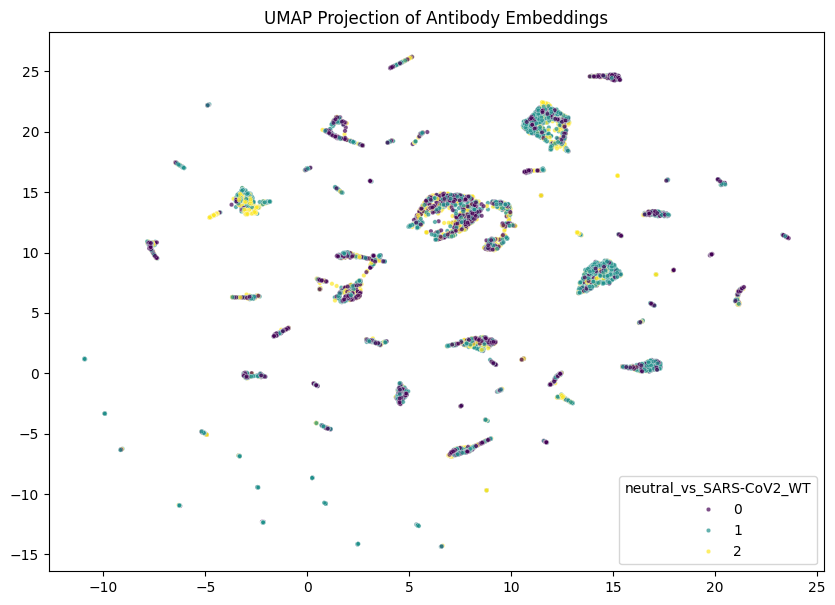

In [16]:
df_processed = pd.read_csv("./naive_processed_features.csv")
# 2. Plot and color by your labels (e.g., 'Clean_Epitope' or 'Neutralization')
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=embedding_2d[:, 0], 
    y=embedding_2d[:, 1], 
    hue=df_processed['neutral_vs_SARS-CoV2_WT'], # Or df['neutralization_label']
    palette='viridis',
    s=10, alpha=0.7
)
plt.title("UMAP Projection of Antibody Embeddings")
plt.show()

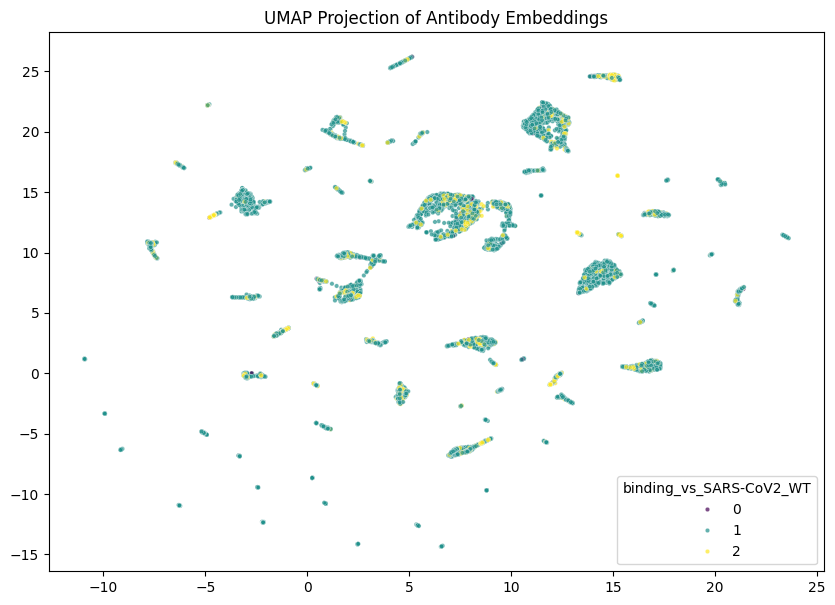

In [ ]:
# 2. Plot and color by your labels (e.g., 'Clean_Epitope' or 'Neutralization')
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=embedding_2d[:, 0], 
    y=embedding_2d[:, 1], 
    hue=df_processed['binding_vs_SARS-CoV2_WT'], # Or df['neutralization_label']
    palette='viridis',
    s=10, alpha=0.7
)
plt.title("UMAP Projection of Antibody Embeddings")
plt.show()